In [1]:
import os
import sys

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score, precision_score, accuracy_score

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sys.path.append("..")

In [3]:
data_dir = os.path.abspath(os.path.join("..", "data"))

In [4]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))

In [5]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [6]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [7]:
df = df.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

In [8]:
# Convert 'Sex' column to binary: male=1, female=0
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})

In [9]:
possible_embarked_values = df["Embarked"].unique().tolist()

In [10]:
embarked_dict = dict()

In [11]:
for i, key in enumerate(possible_embarked_values):
    if key not in embarked_dict:
        embarked_dict[i] = key

In [12]:
embarked_dict

{0: 'S', 1: 'C', 2: 'Q', 3: nan}

In [13]:
# need to delete nan to impute later
del embarked_dict[3]

In [14]:
embarked_dict

{0: 'S', 1: 'C', 2: 'Q'}

In [15]:
df['Embarked'] = df['Embarked'].map(embarked_dict)

In [16]:
# Set imputers for columns that need to have possible nans filled
numeric_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
categorical_imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

In [17]:
# Identify numeric columns that need to be standardized
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', numeric_imputer),
    ('scaler', StandardScaler())
])

In [18]:
# Identify categorical columns that need to be one-hot encoded
categorical_features = ['Sex', 'Embarked', 'Pclass']
categorical_transformer = Pipeline(steps=[
    ('imputer', categorical_imputer),
    ('onehot', OneHotEncoder(drop='first'))
])

In [19]:
# Create the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [20]:
# Create the PCA transformer
pca = PCA(n_components=2)

In [21]:
# Create and evaluate the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('pca', pca)])

In [22]:
X_pca = pipeline.fit_transform(df.drop('Survived', axis=1))

/home/main/.local/share/virtualenvs/cosc_523_project_1-2Raf9G9t/lib/python3.10/site-packages/sklearn/impute/_base.py:558: UserWarning: Skipping features without any observed values: ['Embarked']. At least one non-missing value is needed for imputation with strategy='most_frequent'.
  warnings.warn(


<Figure size 1200x600 with 0 Axes>

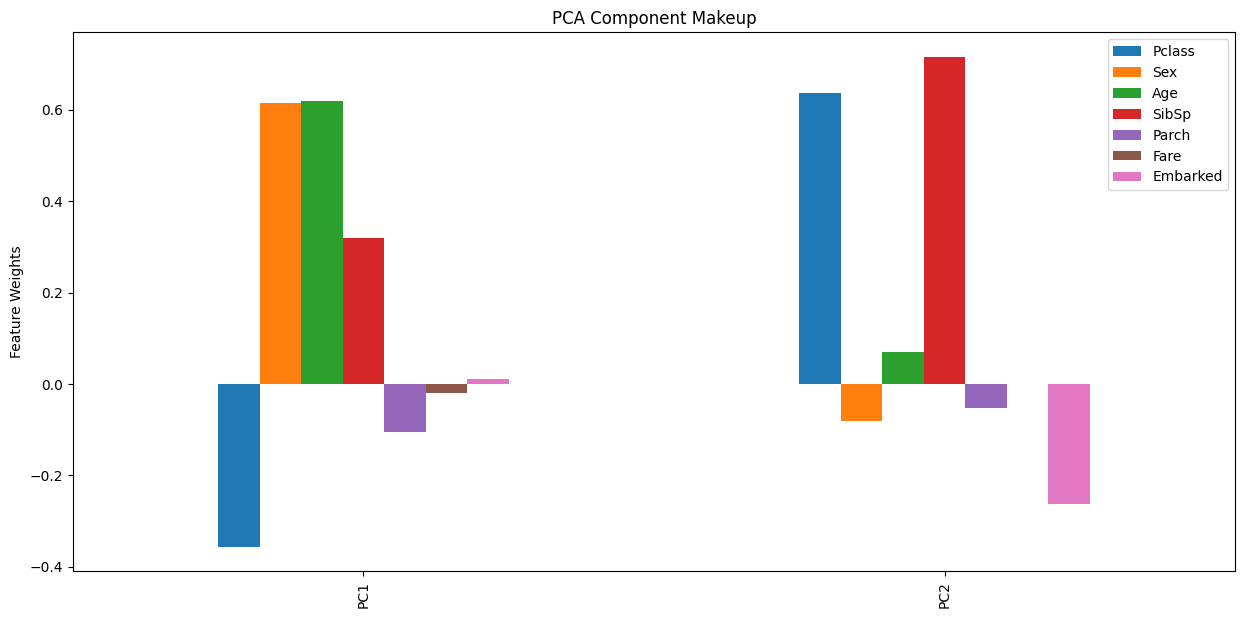

In [23]:
# Extract the PCA component's data
components = pipeline.named_steps['pca'].components_

# Create a dataframe for this data for easier plotting
components_df = pd.DataFrame(components, columns=df.drop('Survived', axis=1).columns, index=[f"PC{i+1}" for i in range(components.shape[0])])

# Visualize the importance of each feature for each principal component
plt.figure(figsize=(12, 6))
components_df.plot(kind='bar', figsize=(15,7))
plt.ylabel('Feature Weights')
plt.title('PCA Component Makeup')
plt.show()

In [24]:
selected_features = ['Parch', 'Pclass', 'Sex', 'Age', 'SibSp']

In [25]:
# Update the feature lists for numeric and categorical transformations
numeric_features = [f for f in numeric_features if f in selected_features]
categorical_features = [f for f in categorical_features if f in selected_features]

In [26]:
# Redefine preprocessor with new features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [27]:
# Add Random Forest Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=523))
])


In [28]:
X = df[selected_features]
y = df['Survived']

In [29]:
X

,Parch,Pclass,Sex,Age,SibSp
0,0,3,1,22.0,1
1,0,1,0,38.0,1
2,0,3,0,26.0,0
3,0,1,0,35.0,1
4,0,3,1,35.0,0
...,...,...,...,...,...
886,0,2,1,27.0,0
887,0,1,0,19.0,0
888,2,3,0,NaN,1
889,0,1,1,26.0,0


In [30]:
# Create train | validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=523)

In [31]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Pclass'])])),
                ('classifier', RandomForestClassifier(random_state=523))])

In [32]:
preds_val = pipeline.predict(X_val)

In [33]:
cm = confusion_matrix(y_val, preds_val)

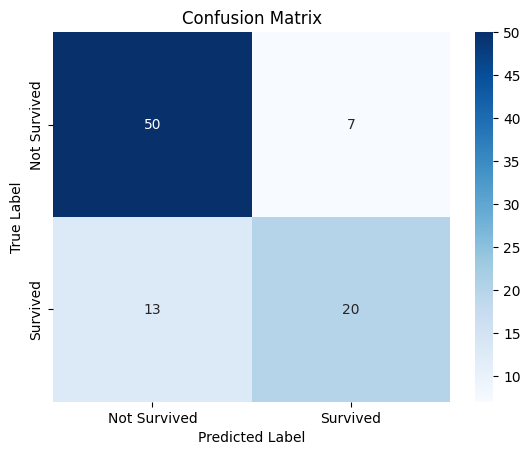

In [34]:
labels = ['Not Survived', 'Survived']
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [35]:
recall = recall_score(y_val, preds_val)
precision = precision_score(y_val, preds_val)
accuracy = accuracy_score(y_val, preds_val)

In [36]:
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Overall Accuracy: {accuracy:.2f}")

Recall: 0.61
Precision: 0.74
Overall Accuracy: 0.78


# Predict on test submission for Kaggle

In [37]:
test = pd.read_csv(os.path.join(data_dir, "test.csv"))

In [38]:
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})

In [39]:
predictions = pipeline.predict(test)

In [40]:
len(predictions)

418

In [41]:
test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",1,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",1,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",1,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",1,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",1,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",1,NaN,0,0,359309,8.0500,NaN,S


In [42]:
preds_df = pd.DataFrame({
    'Survived': predictions,
    'PassengerId': test['PassengerId'],
})


In [43]:
preds_df.to_csv('predictions.csv', index=False)